1. IMPORTAR LIBRERIAS , VERIFICACION DE VERSIONES ESENCIALES Y RECURSOS DE HARDWARE GPU T4

In [1]:
# Instalar rsync es una herramienta de copia de archivos rápida y extraordinariamente versátil.
!apt-get install rsync
# Instalar libreria para poder visualizar en forma grafica la arquitenctura de la red neuronal
!pip install visualkeras


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
rsync is already the newest version (3.2.7-0ubuntu0.22.04.4).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 27.1 MB/s eta 0:00:00


In [2]:
# 1.1 Librerías esenciales

import shutil
import random
from PIL import Image
import pandas as pd
import tensorflow as tf  # <-- importar tensorflow

# Configuración inicial de GPU (debe ir inmediatamente después del import)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')


from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf  # <-- importar tensorflow
import os
import numpy as np # linear algebra
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, regularizers
from sklearn.utils.class_weight import compute_class_weight
import random
import cv2
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from collections import OrderedDict
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
import visualkeras

import gc

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import load_model






In [3]:
# 1.2 Verificamos si la version de Tensorflow es la que se necesita
print("TF Version:", tf.__version__) # debe ser 2.18.0

TF Version: 2.18.0


In [4]:
# 1. Configuración inicial de GPU (al principio del todo)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Configurando GPUs...")
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("No se detectaron GPUs, usando CPU")

Configurando GPUs...


In [5]:
# 2. Clase personalizada para monitorear memoria (definir antes de usarla)
class MemoryMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.memory_usage = []

    def on_epoch_begin(self, epoch, logs=None):
        if physical_devices:
            memory_info = tf.config.experimental.get_memory_info('GPU:0')
            current_mem = memory_info['current'] / (1024**3)  # Convertir a GB
            self.memory_usage.append(current_mem)
            print(f" Memoria GPU usada: {current_mem:.2f} GB")

In [6]:
# 1.3 Verificar existe disponibilidad de GPU en Google Drive
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# 1.4 Visualizacion de GPU T4
!nvidia-smi

Sun May 18 22:03:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

2. DEFINIR RUTAS DE ACCESO DE GOOGLE COLAB A GOOGLE DRIVE Y CARGAR DATASETS KAGGLE

In [8]:
# 2.1) Se define la ruta para leer los archivos a usar desde la nube Google Colaboratory
     # a Google Drive
BASE_FOLDER = '/content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA/'

# Instruccion que permite importar y montar una unidad de Drive de Google drive en Google colaboratory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# 2.3 ) Se ubica el archivo token generado por la cuenta Kaggle en Google drive
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Descargar dataset
!kaggle datasets download -d ayuraj/asl-dataset
!unzip -q asl-dataset.zip -d /content/data/
# Visualizar el dataset
!ls /content/data/asl_dataset

Dataset URL: https://www.kaggle.com/datasets/ayuraj/asl-dataset
License(s): CC0-1.0
  0% 0.00/56.9M [00:00<?, ?B/s]
100% 56.9M/56.9M [00:00<00:00, 1.36GB/s]
0  2  4  6  8  a	    b  d  f  h	j  l  n  p  r  t  v  x	z
1  3  5  7  9  asl_dataset  c  e  g  i	k  m  o  q  s  u  w  y


3. LIMPIEZA DE DATOS

In [10]:
# Copiar todo el contenido recursivamente (incluyendo subcarpetas)
!rsync -a /content/data/asl_dataset/asl_dataset/ /content/data/asl_dataset/

# Eliminar la carpeta duplicada (ahora vacía)
!rm -rf /content/data/asl_dataset/asl_dataset

# Visualizar los cambios
!ls /content/data/asl_dataset

0  2  4  6  8  a  c  e	g  i  k  m  o  q  s  u	w  y
1  3  5  7  9  b  d  f	h  j  l  n  p  r  t  v	x  z


In [11]:
# Se navega dentro del directorio
%cd /content/data/asl_dataset

# Se eliminan las carpetas con numeros del 0 al 9
!rm -rf 0 1 2 3 4 5 6 7 8 9

# Se visualizan los cambios
!ls

/content/data/asl_dataset
a  b  c  d  e  f  g  h	i  j  k  l  m  n  o  p	q  r  s  t  u  v  w  x	y  z


In [12]:
# Se convierten las carpetas de letras minusculas a mayusculas
dataset_dir = '/content/data/asl_dataset'

# Lista de clases esperadas (26 en total)
valid_classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
           ]

# Renombrar carpetas de minúsculas a mayúsculas
for class_name in valid_classes:
    lowercase_path = os.path.join(dataset_dir, class_name.lower())
    correct_path = os.path.join(dataset_dir, class_name)

    if os.path.exists(lowercase_path):
        os.rename(lowercase_path, correct_path)
        print(f"Renombrado: {class_name.lower()} -> {class_name}")

print("¡Estructura corregida!")

Renombrado: a -> A
Renombrado: b -> B
Renombrado: c -> C
Renombrado: d -> D
Renombrado: e -> E
Renombrado: f -> F
Renombrado: g -> G
Renombrado: h -> H
Renombrado: i -> I
Renombrado: j -> J
Renombrado: k -> K
Renombrado: l -> L
Renombrado: m -> M
Renombrado: n -> N
Renombrado: o -> O
Renombrado: p -> P
Renombrado: q -> Q
Renombrado: r -> R
Renombrado: s -> S
Renombrado: t -> T
Renombrado: u -> U
Renombrado: v -> V
Renombrado: w -> W
Renombrado: x -> X
Renombrado: y -> Y
Renombrado: z -> Z
¡Estructura corregida!


In [13]:
# 3.1.2 Verificamos si el dataset esta balanceado es decir si todas las clases tiene el mismo numero de imagenes
data_dir = '/content/data/asl_dataset'
for cls in valid_classes:  # ['A', 'B', ..., 'Z']
    cls_dir = os.path.join(data_dir, cls)
    num_images = len(os.listdir(cls_dir))
    print(f"Clase {cls}: {num_images} imágenes")

Clase A: 70 imágenes
Clase B: 70 imágenes
Clase C: 70 imágenes
Clase D: 70 imágenes
Clase E: 70 imágenes
Clase F: 70 imágenes
Clase G: 70 imágenes
Clase H: 70 imágenes
Clase I: 70 imágenes
Clase J: 70 imágenes
Clase K: 70 imágenes
Clase L: 70 imágenes
Clase M: 70 imágenes
Clase N: 70 imágenes
Clase O: 70 imágenes
Clase P: 70 imágenes
Clase Q: 70 imágenes
Clase R: 70 imágenes
Clase S: 70 imágenes
Clase T: 65 imágenes
Clase U: 70 imágenes
Clase V: 70 imágenes
Clase W: 70 imágenes
Clase X: 70 imágenes
Clase Y: 70 imágenes
Clase Z: 70 imágenes


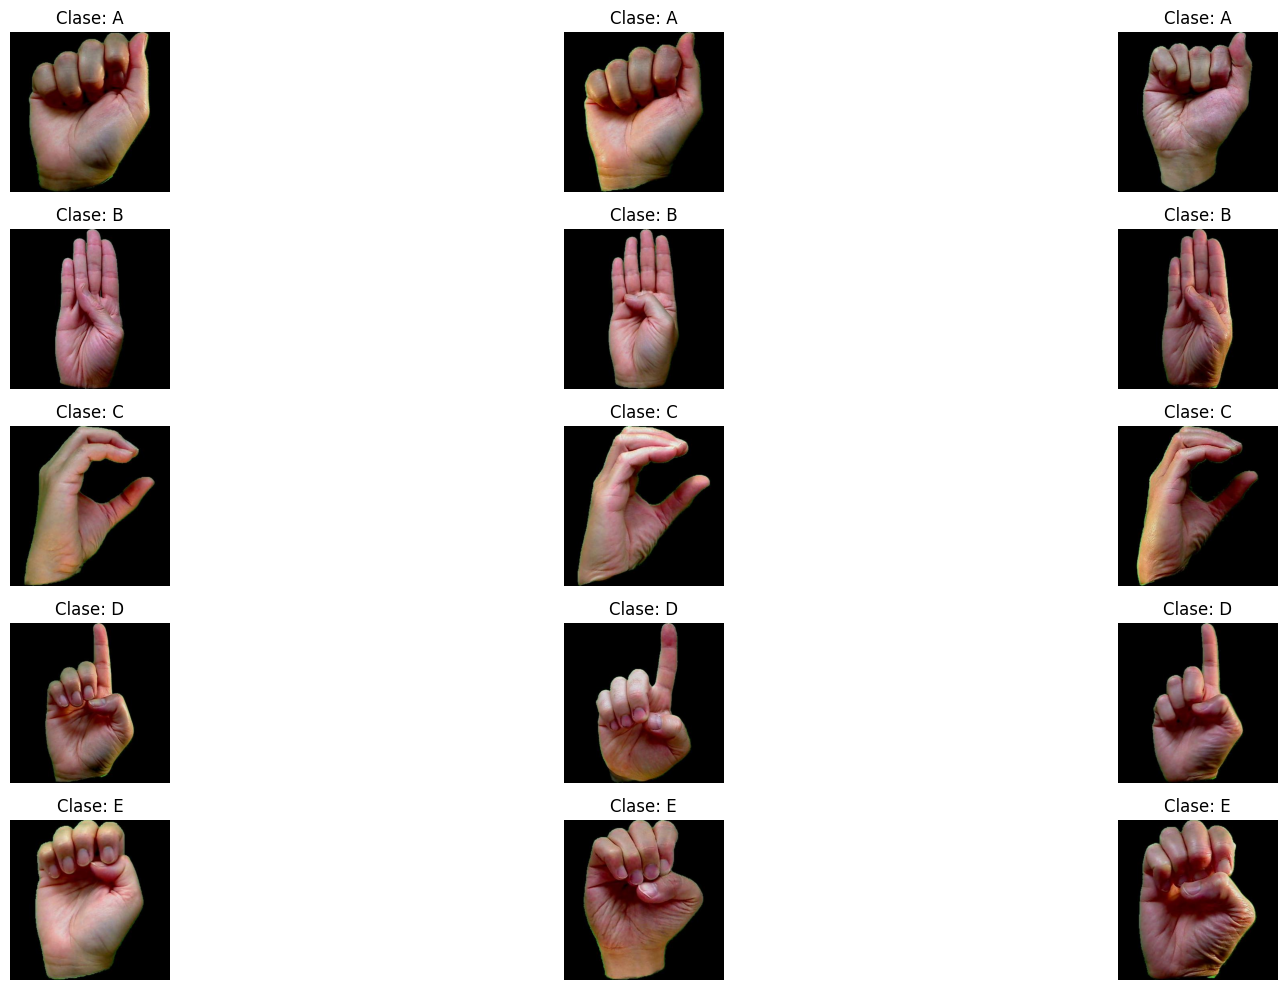

In [14]:

data_dir = '/content/data/asl_dataset'
clases = sorted(os.listdir(data_dir))  # ['A', 'B', ..., 'Z']

# Configurar la visualización
num_clases = 5  # Clases a mostrar (ajusta este valor)
imagenes_por_clase = 3  # Imágenes por clase

plt.figure(figsize=(20, 10))

for i, clase in enumerate(clases[:num_clases]):
    clase_path = os.path.join(data_dir, clase)

    # Listar solo archivos .jpeg (ignorar otros formatos)
    imagenes = [f for f in os.listdir(clase_path) if f.endswith('.jpeg')]

    # Tomar las primeras "imagenes_por_clase" imágenes
    for j in range(imagenes_por_clase):
        imagen_path = os.path.join(clase_path, imagenes[j])
        img = cv2.imread(imagen_path)

        # Verificar que la imagen se cargó correctamente
        if img is None:
            print(f"Error al cargar: {imagen_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir a RGB

        # Mostrar en la cuadrícula
        plt.subplot(num_clases, imagenes_por_clase, i * imagenes_por_clase + j + 1)
        plt.imshow(img)
        plt.title(f'Clase: {clase}')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:

# Configuración
data_dir = '/content/data/asl_dataset'
base_dir = '/content/data'
test_frac = 0.15  # 15% para prueba
k_folds = 5       # Número de folds

# Limpiar directorios anteriores
shutil.rmtree(os.path.join(base_dir, 'test'), ignore_errors=True)
for fold in range(k_folds):
    shutil.rmtree(os.path.join(base_dir, f'train_fold{fold}'), ignore_errors=True)
    shutil.rmtree(os.path.join(base_dir, f'val_fold{fold}'), ignore_errors=True)

# Crear directorios
os.makedirs(os.path.join(base_dir, 'test'), exist_ok=True)

for clase in sorted(os.listdir(data_dir)):
    clase_path = os.path.join(data_dir, clase)
    imagenes = os.listdir(clase_path)

    # 1. Split inicial: Test (15%) vs Train+Val (85%)
    train_val_imgs, test_imgs = train_test_split(
        imagenes,
        test_size=test_frac,
        random_state=42,
        shuffle=True
    )

    # Crear directorio de test para la clase
    test_clase_dir = os.path.join(base_dir, 'test', clase)
    os.makedirs(test_clase_dir, exist_ok=True)
    for img in test_imgs:
        shutil.copy(os.path.join(clase_path, img),
                    os.path.join(test_clase_dir, img))

    # 2. Aplicar K-Fold en el conjunto Train+Val
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    for fold_idx, (train_index, val_index) in enumerate(kf.split(train_val_imgs)):
        # Crear directorios para el fold actual
        train_fold_dir = os.path.join(base_dir, f'train_fold{fold_idx}', clase)
        val_fold_dir = os.path.join(base_dir, f'val_fold{fold_idx}', clase)
        os.makedirs(train_fold_dir, exist_ok=True)
        os.makedirs(val_fold_dir, exist_ok=True)

        # Obtener imágenes para este fold
        fold_train = [train_val_imgs[i] for i in train_index]
        fold_val = [train_val_imgs[i] for i in val_index]

        # Copiar imágenes a los directorios del fold
        for img in fold_train:
            shutil.copy(os.path.join(clase_path, img),
                        os.path.join(train_fold_dir, img))

        for img in fold_val:
            shutil.copy(os.path.join(clase_path, img),
                        os.path.join(val_fold_dir, img))

print("¡División con K-Folds completada!")

¡División con K-Folds completada!




================ FOLD 0 ================
✓ Orden correcto en Train Fold 0


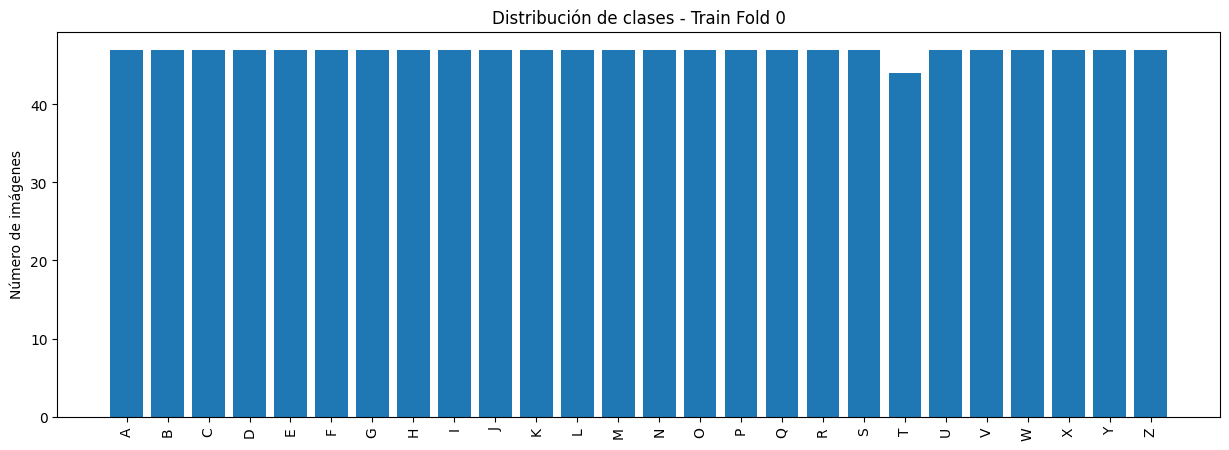


Train Fold 0 - Estadísticas:
Total clases: 26
Total imágenes: 1219
Mínimo: 44
Máximo: 47
-----------------------------------
✓ Orden correcto en Val Fold 0


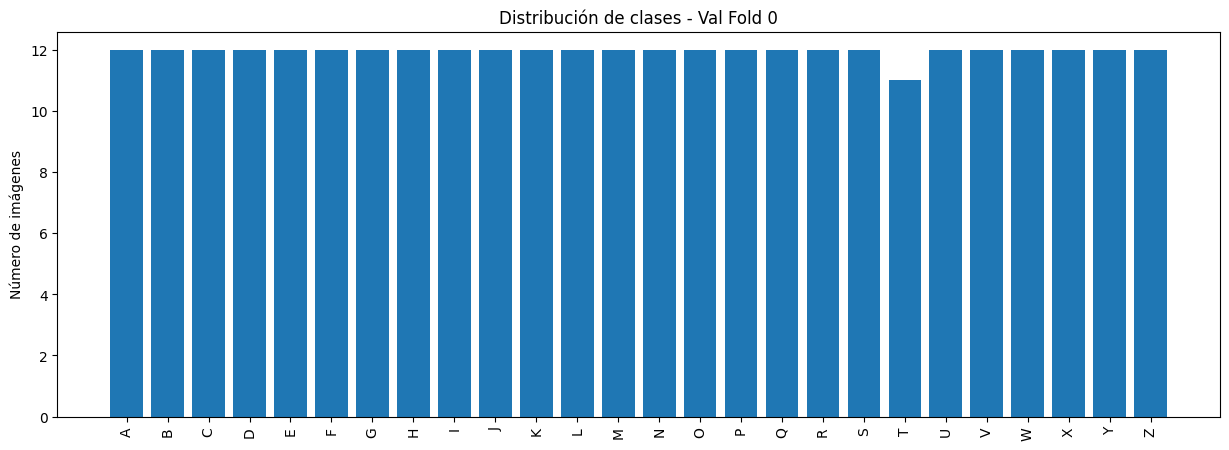


Val Fold 0 - Estadísticas:
Total clases: 26
Total imágenes: 311
Mínimo: 11
Máximo: 12
-----------------------------------


================ FOLD 1 ================
✓ Orden correcto en Train Fold 1


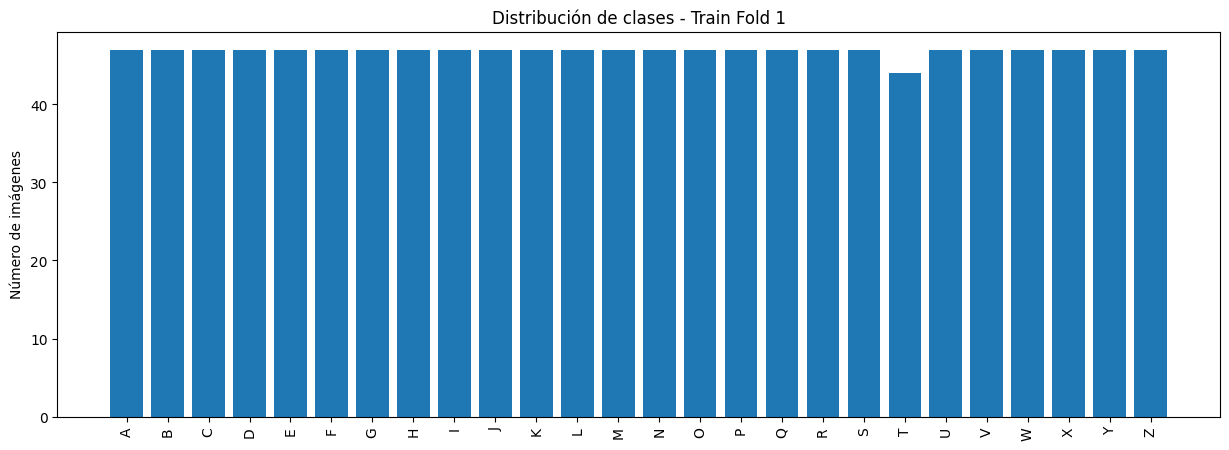


Train Fold 1 - Estadísticas:
Total clases: 26
Total imágenes: 1219
Mínimo: 44
Máximo: 47
-----------------------------------
✓ Orden correcto en Val Fold 1


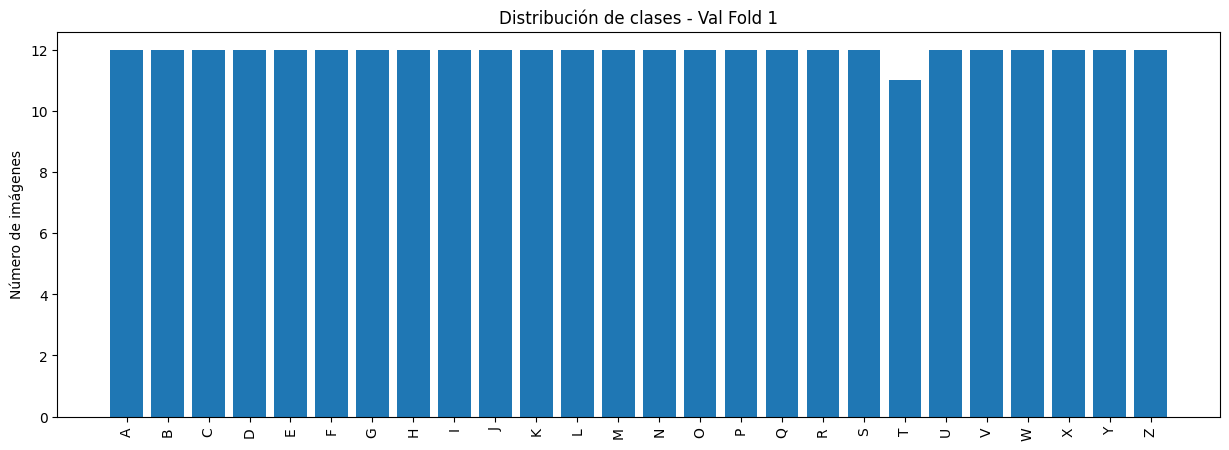


Val Fold 1 - Estadísticas:
Total clases: 26
Total imágenes: 311
Mínimo: 11
Máximo: 12
-----------------------------------


================ FOLD 2 ================
✓ Orden correcto en Train Fold 2


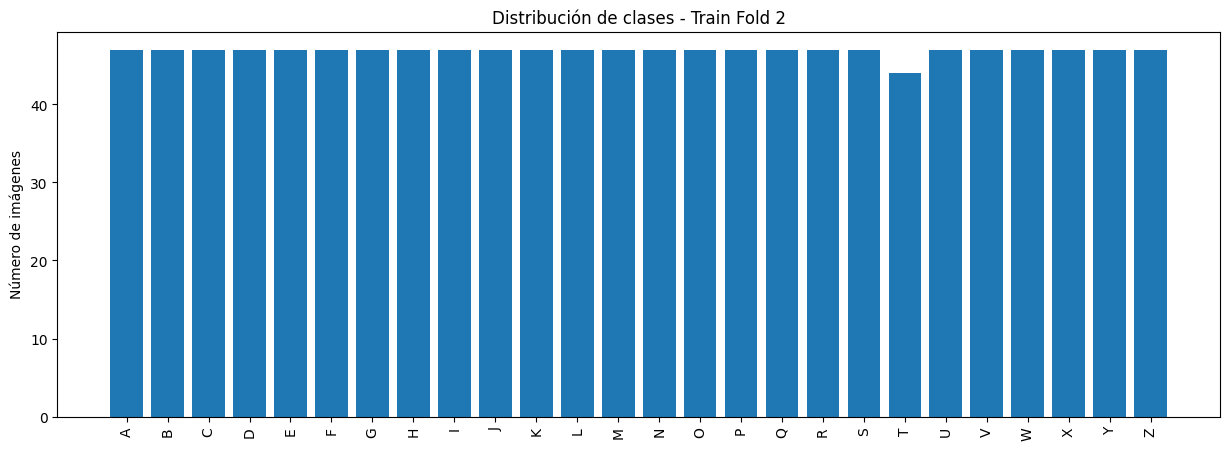


Train Fold 2 - Estadísticas:
Total clases: 26
Total imágenes: 1219
Mínimo: 44
Máximo: 47
-----------------------------------
✓ Orden correcto en Val Fold 2


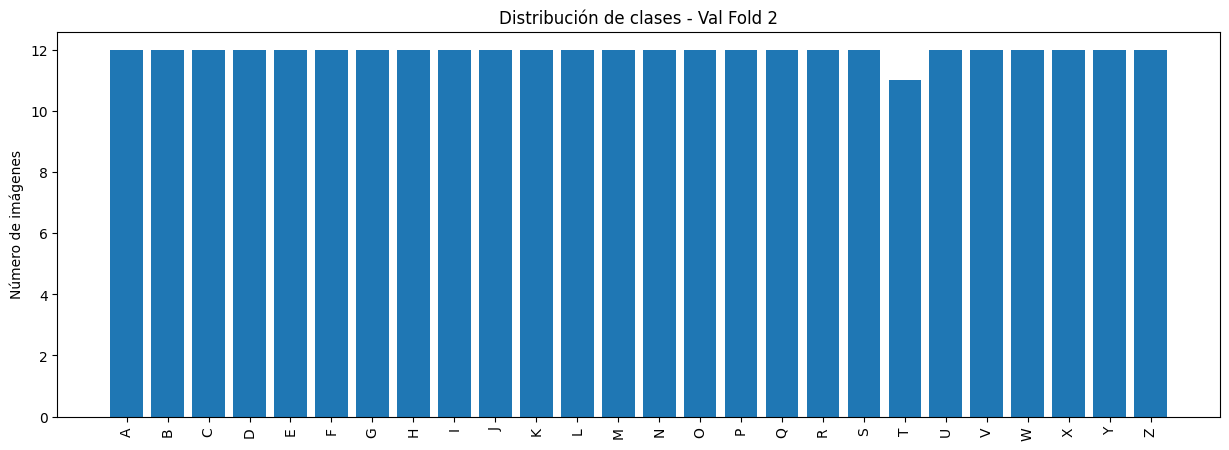


Val Fold 2 - Estadísticas:
Total clases: 26
Total imágenes: 311
Mínimo: 11
Máximo: 12
-----------------------------------


================ FOLD 3 ================
✓ Orden correcto en Train Fold 3


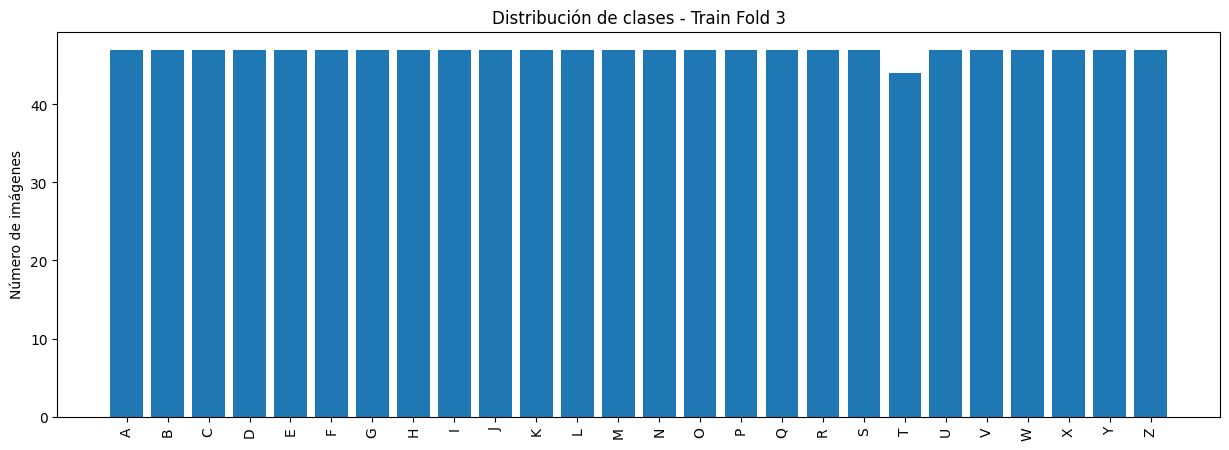


Train Fold 3 - Estadísticas:
Total clases: 26
Total imágenes: 1219
Mínimo: 44
Máximo: 47
-----------------------------------
✓ Orden correcto en Val Fold 3


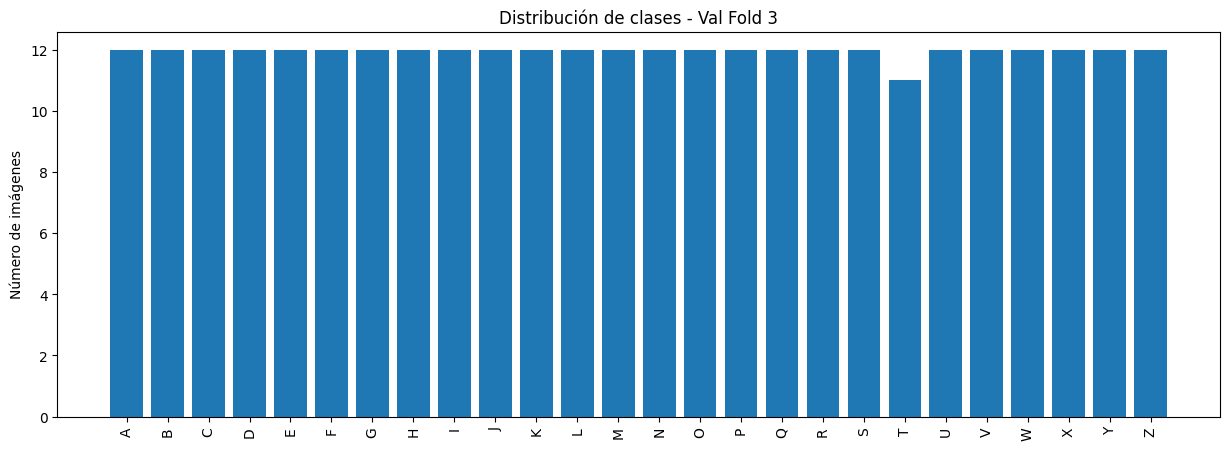


Val Fold 3 - Estadísticas:
Total clases: 26
Total imágenes: 311
Mínimo: 11
Máximo: 12
-----------------------------------


================ FOLD 4 ================
✓ Orden correcto en Train Fold 4


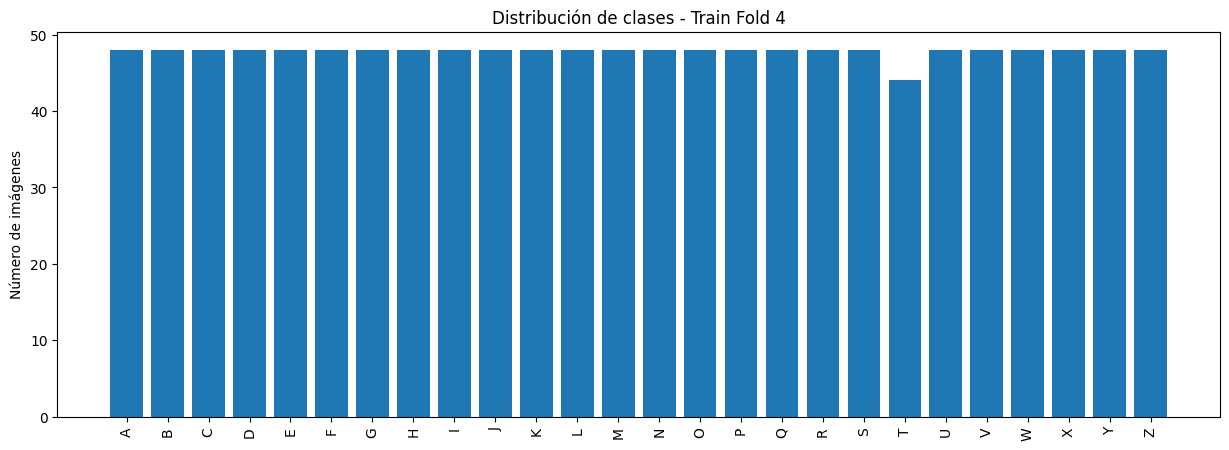


Train Fold 4 - Estadísticas:
Total clases: 26
Total imágenes: 1244
Mínimo: 44
Máximo: 48
-----------------------------------
✓ Orden correcto en Val Fold 4


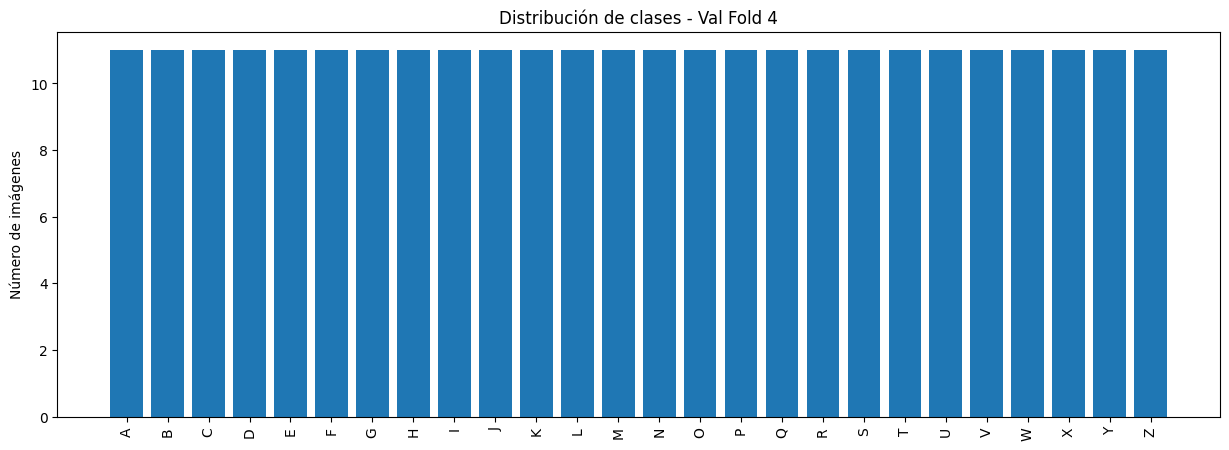


Val Fold 4 - Estadísticas:
Total clases: 26
Total imágenes: 286
Mínimo: 11
Máximo: 11
-----------------------------------


================ TEST SET ================
✓ Orden correcto en Test Set


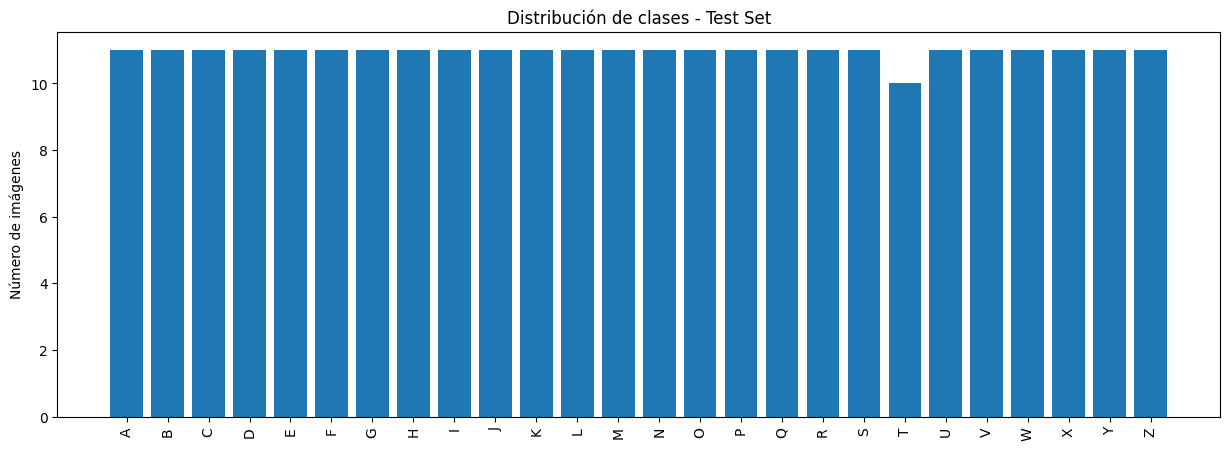


Test Set - Estadísticas:
Total clases: 26
Total imágenes: 285
Mínimo: 10
Máximo: 11
-----------------------------------


================ DATASET ORIGINAL ================


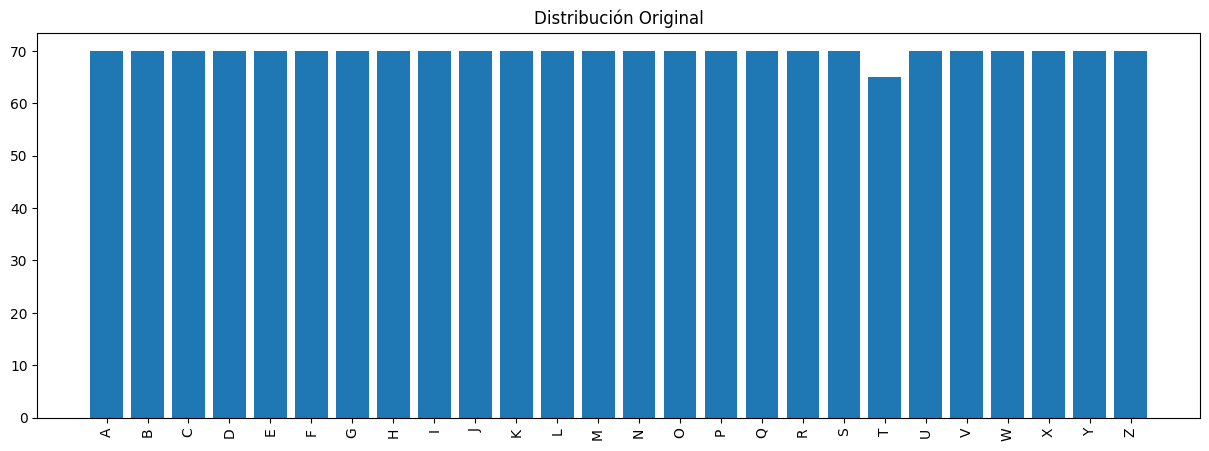

In [16]:

def plot_class_distribution(directory, title, expected_order):
    class_counts = OrderedDict()
    classes = sorted(os.listdir(directory))

    # Verificar orden
    if classes != expected_order:
        print(f"⚠️ Orden incorrecto en {title}: {classes}")
    else:
        print(f"✓ Orden correcto en {title}")

    # Contar imágenes por clase
    for cls in classes:
        cls_path = os.path.join(directory, cls)
        class_counts[cls] = len(os.listdir(cls_path))

    # Gráfico
    plt.figure(figsize=(15, 5))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title(f'Distribución de clases - {title}')
    plt.xticks(rotation=90)
    plt.ylabel('Número de imágenes')
    plt.show()

    # Estadísticas
    print(f"\n{title} - Estadísticas:")
    print(f"Total clases: {len(class_counts)}")
    print(f"Total imágenes: {sum(class_counts.values())}")
    print(f"Mínimo: {min(class_counts.values())}")
    print(f"Máximo: {max(class_counts.values())}")
    print("-----------------------------------")

# Obtener orden esperado (A-Z)
original_classes = sorted(os.listdir(data_dir))

# Verificar distribución en cada fold
for fold in range(k_folds):
    print(f"\n\n================ FOLD {fold} ================")
    # Entrenamiento
    plot_class_distribution(
        os.path.join(base_dir, f'train_fold{fold}'),
        f'Train Fold {fold}',
        original_classes
    )

    # Validación
    plot_class_distribution(
        os.path.join(base_dir, f'val_fold{fold}'),
        f'Val Fold {fold}',
        original_classes
    )

# Verificar test
print("\n\n================ TEST SET ================")
plot_class_distribution(
    os.path.join(base_dir, 'test'),
    'Test Set',
    original_classes
)

# Verificar dataset original
print("\n\n================ DATASET ORIGINAL ================")
original_counts = OrderedDict()
for cls in original_classes:
    cls_path = os.path.join(data_dir, cls)
    original_counts[cls] = len(os.listdir(cls_path))

plt.figure(figsize=(15, 5))
plt.bar(original_counts.keys(), original_counts.values())
plt.title('Distribución Original')
plt.xticks(rotation=90)
plt.show()

4. VALIDACION DE LA RED NEURONAL ARTIFICIAL SECUENCIAL DE CLASIFICACION

In [17]:
# Se verifican las dimensiones de las imagenes en formato JPEG

data_dir = '/content/data/asl_dataset'
clase_ejemplo = 'A'  # Reemplaza con una clase existente
imagen_ejemplo = os.listdir(os.path.join(data_dir, clase_ejemplo))[0]
imagen_path = os.path.join(data_dir, clase_ejemplo, imagen_ejemplo)

# Obtener dimensiones
with Image.open(imagen_path) as img:
    width, height = img.size

print(f"Dimensiones originales: {width}x{height}")

Dimensiones originales: 400x400


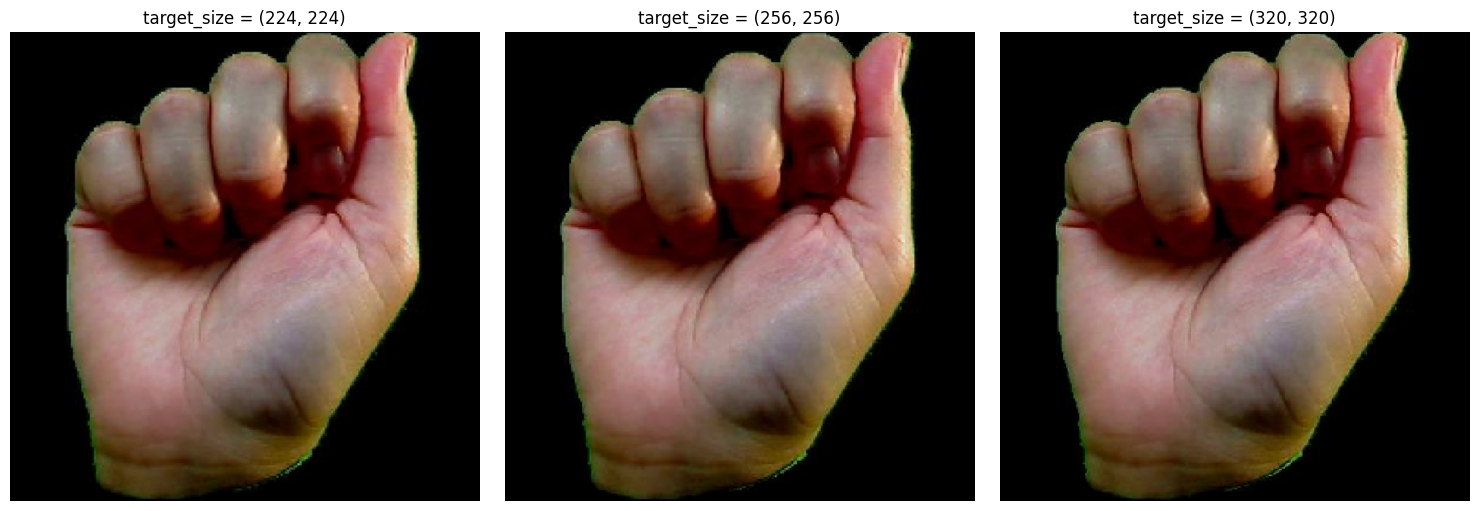

In [18]:

# Tamaños a probar de target_size antes de configurar ImageDataGenerator
tamanos = [(224, 224), (256, 256), (320, 320)]

plt.figure(figsize=(15, 5))

for i, size in enumerate(tamanos):
    # Cargar y redimensionar imagen
    img = load_img(imagen_path, target_size=size)

    plt.subplot(1, len(tamanos), i + 1)
    plt.imshow(img)
    plt.title(f'target_size = {size}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Configuración común
target_size = (256, 256)  # Ajustar según modelo
batch_size = 32
class_mode = 'categorical'  # on hot
color_mode='rgb'


# Data augmentation para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,          # Manos pueden rotar más
    width_shift_range=0.1,     # Desplazamiento horizontal
    height_shift_range=0.1,    # Desplazamiento vertical
    zoom_range=0.15,             # Zoom para simular distancia
    shear_range=0.15,           # Deformación por perspectiva
    brightness_range=[0.5, 1.5],# Variación de brillo
    channel_shift_range=50,     # Cambios de tono (simula luces coloreadas)
    fill_mode='constant',       # Rellenar fondos con negro
    cval=0.0                    # Valor de relleno=negro
)

# Generador para validación y test (solo rescale)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Diccionario para almacenar los generadores por fold
train_generators = {}
val_generators = {}

# Crear generadores para cada fold
for fold in range(k_folds):
    # Directorios para este fold
    train_dir = os.path.join(base_dir, f'train_fold{fold}')
    val_dir = os.path.join(base_dir, f'val_fold{fold}')

    # Generadores de entrenamiento y validación
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        color_mode=color_mode,
        class_mode=class_mode,
        shuffle=True,
        seed=42,

    )

    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        color_mode=color_mode,
        class_mode=class_mode,
        shuffle=False  # Importante para evaluación
    )

    # Almacenar en el diccionario
    train_generators[f'fold{fold}'] = train_generator
    val_generators[f'fold{fold}'] = val_generator

# Generador para el conjunto de prueba
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=target_size,
    batch_size=batch_size,
    color_mode=color_mode,
    class_mode=class_mode,
    shuffle=False  # Fundamental para métricas confiables
)

# Verificar las asignaciones de clases
print("\nMapeo de clases:", train_generator.class_indices)

Found 1219 images belonging to 26 classes.
Found 311 images belonging to 26 classes.
Found 1219 images belonging to 26 classes.
Found 311 images belonging to 26 classes.
Found 1219 images belonging to 26 classes.
Found 311 images belonging to 26 classes.
Found 1219 images belonging to 26 classes.
Found 311 images belonging to 26 classes.
Found 1244 images belonging to 26 classes.
Found 286 images belonging to 26 classes.
Found 285 images belonging to 26 classes.

Mapeo de clases: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


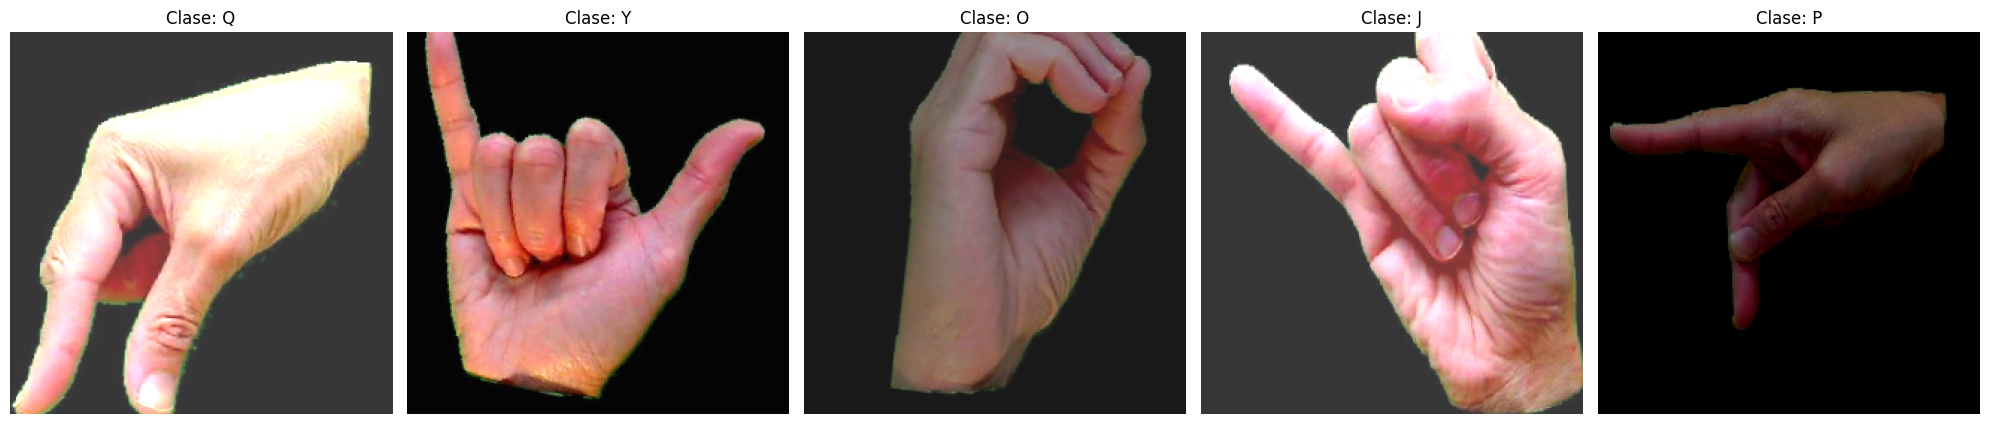


Shape de las imágenes: (32, 256, 256, 3)
Shape de las etiquetas: (32, 26)
Valores de píxeles: 0.0 1.0


In [20]:
# Obtener un batch de datos
images, labels = next(train_generator)

# Crear figura con 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Obtener el mapeo de clases
class_names = list(train_generator.class_indices.keys())

# Mostrar 5 primeras imágenes del batch
for i in range(5):
    ax = axes[i]

    # Mostrar imagen en escala de grises real
    ax.imshow(images[i].squeeze(), cmap='gray')  # Eliminar dimensión de canal con .squeeze()

    # Obtener etiqueta verdadera
    true_label = class_names[np.argmax(labels[i])]

    ax.set_title(f"Clase: {true_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Verificar shape de los datos
print("\nShape de las imágenes:", images.shape) # Debe ser (batch, 256, 256, 3)
print("Shape de las etiquetas:", labels.shape) # Debe ser (batch, 256, 256, 3)
print("Valores de píxeles:", np.min(images), np.max(images))  # Deben estar en [0,1]

In [21]:
 #definiciones
image_shape = (256, 256, 3)  # (height, width, channels)
class_indices = 26

# Valores extraídos del generador (¡Deben coincidir!)
input_shape = train_generators['fold0'].image_shape  # Debería ser (300, 300, 3)
num_classes = len(train_generators['fold0'].class_indices)  # Debería ser 26

print(f"Input shape del generador: {input_shape}")  # Debe mostrar (300, 300, 3)
print(f"Número de clases del generador: {num_classes}")  # Debe mostrar 26

Input shape del generador: (256, 256, 3)
Número de clases del generador: 26


In [22]:
# Crear modelo simplificado para debug
debug_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    Flatten(),
    Dense(26, activation='softmax')
])
debug_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar solo con 1 batch
sample_images, sample_labels = next(train_generator)
history = debug_model.fit(
    sample_images,
    sample_labels,
    epochs=20,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.0000e+00 - loss: 3.2735
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0938 - loss: 21.8937
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2500 - loss: 41.6490
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.4062 - loss: 58.8785
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5938 - loss: 68.4900
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6562 - loss: 69.5605
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7188 - loss: 61.8811
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6875 - loss: 52.1068
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6562 - loss: 43.5133
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7188 - loss: 30.8157
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7812 - loss: 19.0674
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7812 

In [24]:
#def create_model(input_shape=input_shape, num_classes=num_classes):
model = Sequential([
        # Capa convolucional inicial
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),

        # Bloque intermedio
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        # Bloque final
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        # Clasificación
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Aseguramos que coincida con class_indices
])

model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    #return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


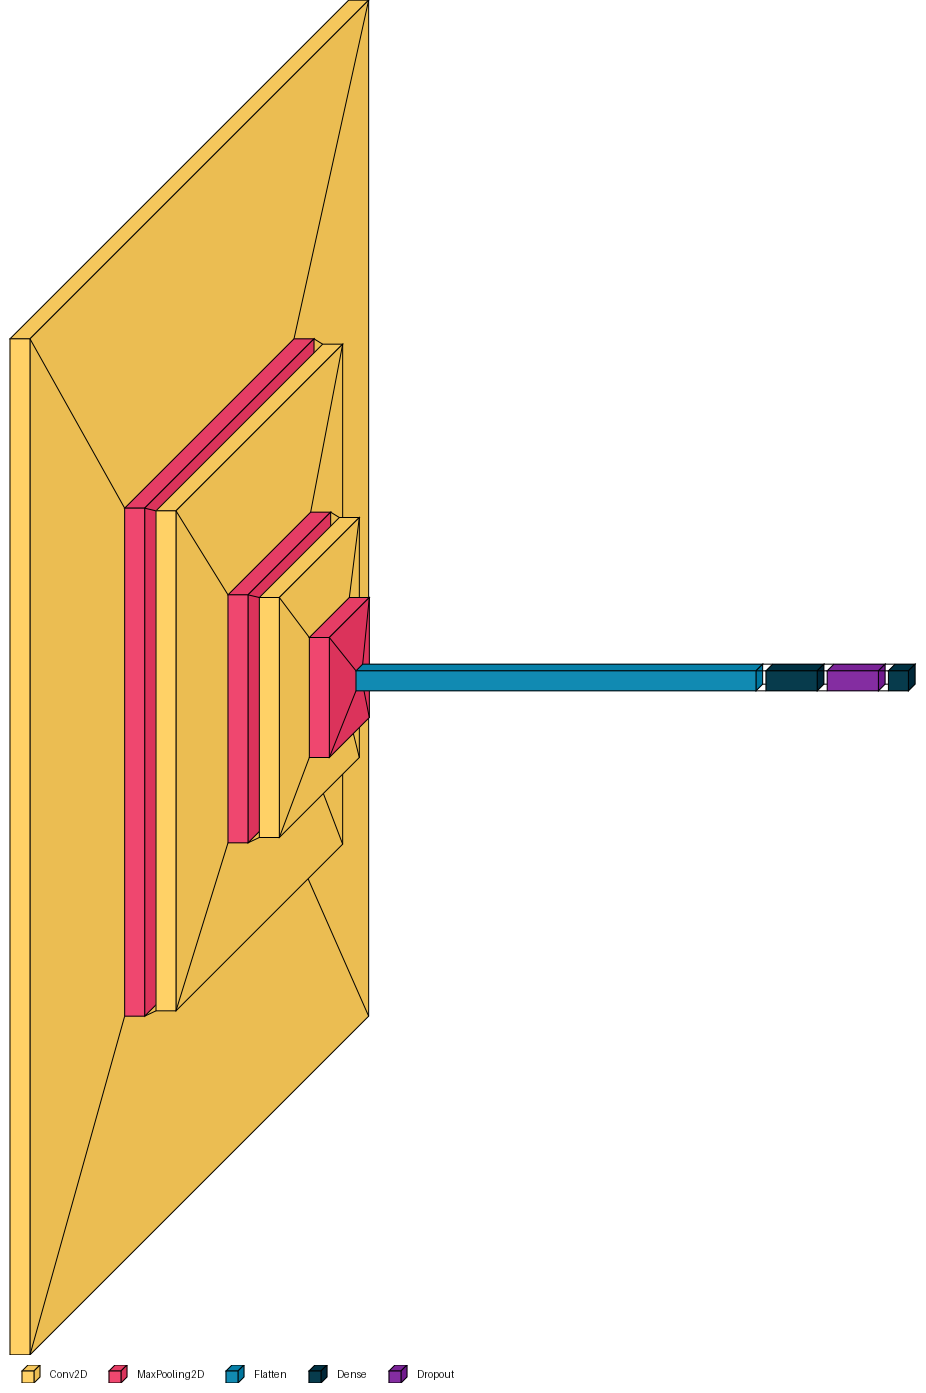

In [25]:
# Se visualiza la red de fomra grafica
visualkeras.layered_view(model,legend=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Si estás en Colab

# Configuración base
image_shape = (256, 256, 3)  # Definición temporal
class_indices = 26  # Definición temporal

# Obtener parámetros dinámicamente del primer generador
input_shape = train_generators['fold0'].image_shape  # (256,256,3)
num_classes = len(train_generators['fold0'].class_indices)  # 26
k_folds = 5
batch_size = 32
epochs = 50

# ------------------------- FUNCIÓN DEL MODELO -------------------------


def create_model(input_shape=input_shape, num_classes=num_classes):
    model = Sequential([
        # Capa convolucional inicial
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),

        # Bloque intermedio
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        # Bloque final
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        # Clasificación
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Aseguramos que coincida con class_indices
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ------------------------- CREAR RUTA -------------------------

drive_path = '/content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA/'

# ------------------------- PIPELINE DE DATOS -------------------------
def create_optimized_dataset(generator):
    return tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, *input_shape), dtype=tf.float32),
            tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
        )
    ).prefetch(tf.data.AUTOTUNE)


# ------------------------- ENTRENAMIENTO -------------------------

for fold in range(k_folds):
    # Limpieza explícita
    tf.keras.backend.clear_session()
    gc.collect()

    print(f"\n═════════ Fold {fold+1}/{k_folds} ═════════")


    # Modelo y datasets
    model = create_model()
    if fold == 0:
        model.summary()

    train_dataset = create_optimized_dataset(train_generators[f'fold{fold}'])
    val_dataset = create_optimized_dataset(val_generators[f'fold{fold}'])

    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        ModelCheckpoint(
            filepath=f'{drive_path}/best_model_fold{fold}.keras',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max',
            verbose=1
       ),
       MemoryMonitor()
    ]

    # Entrenamiento sin warmup (configuración simple)
    history = model.fit(
        train_dataset,
        epochs= epochs,
        steps_per_epoch=train_generators[f'fold{fold}'].n // batch_size,
        validation_data=val_dataset,
        validation_steps=val_generators[f'fold{fold}'].n // batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluación
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\nTest Accuracy Fold {fold}: {test_acc:.2%}")

    # Limpieza explícita
    del model, train_dataset, val_dataset
    tf.keras.backend.clear_session()
    gc.collect()





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

═════════ Fold 1/5 ═════════


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,089,498 (225.41 MB)

 Trainable params: 59,089,498 (225.41 MB)

 Non-trainable params: 0 (0.00 B)

 Memoria GPU usada: 0.95 GB
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.0812 - loss: 3.5882
Epoch 1: val_accuracy improved from -inf to 0.55208, saving model to /content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA//best_model_fold0.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 908ms/step - accuracy: 0.0824 - loss: 3.5765 - val_accuracy: 0.5521 - val_loss: 1.6929 - learning_rate: 0.0010
 Memoria GPU usada: 1.42 GB
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.3197 - loss: 2.2126
Epoch 2: val_accuracy improved from 0.55208 to 0.71685, saving model to /content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA//best_model_fold0.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 968ms/step - accuracy: 0.3203 - loss: 2.2105 - val_accuracy: 0.7168 - val_loss: 0.8876 - learning_rate: 0.0010
 Memoria GPU usada: 1.42 GB
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.4461 - loss: 1.8628
Epoch 3: val_accuracy improved from 0.71685 to 0.77061, saving model 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step - accuracy: 0.9938 - loss: 0.0305

Test Accuracy Fold 0: 99.30%

═════════ Fold 2/5 ═════════
 Memoria GPU usada: 1.76 GB
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.0757 - loss: 3.4251
Epoch 1: val_accuracy improved from -inf to 0.52431, saving model to /content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA//best_model_fold1.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 829ms/step - accuracy: 0.0769 - loss: 3.4166 - val_accuracy: 0.5243 - val_loss: 1.7071 - learning_rate: 0.0010
 Memoria GPU usada: 2.32 GB
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.3474 - loss: 2.2502
Epoch 2: val_accuracy improved from 0.52431 to 0.73835, saving model to /content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA//best_model_fold1.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 978ms/step - accuracy: 0.3479 - loss: 2.2472 - val_accuracy: 0.7384 - val_loss: 0.8147 - learning_rate: 0.0010
 Memoria GPU usada: 2.32 GB
Epoch 3/50
38/38 ━━━━━

In [ ]:
# =============================================
# 4.5 Guardar dataset de Test
# =============================================

from google.colab import drive
drive.mount('/content/drive')
# Copiar el directorio test a Google Drive
!cp -r '/content/data/test' '/content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA/test_dataset'

# Verificar que el archivo existe

if os.path.exists('/content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA/test_dataset'):
    print("✅ Modelo guardado correctamente en Drive!")
else:
    print("❌ Error: Revisa la ruta.")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Modelo guardado correctamente en Drive!


In [ ]:
# =============================================
# 4.5 Guardar Modelo
# =============================================

# Verificar que el archivo existe

if os.path.exists('/content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA/best_model_fold4.keras'):
    print("✅ Modelo guardado correctamente en Drive!")
else:
    print("❌ Error: Revisa la ruta.")


✅ Modelo guardado correctamente en Drive!


5. PRESENTACION DE LOS RESULTADOS DE LA EVALUACION

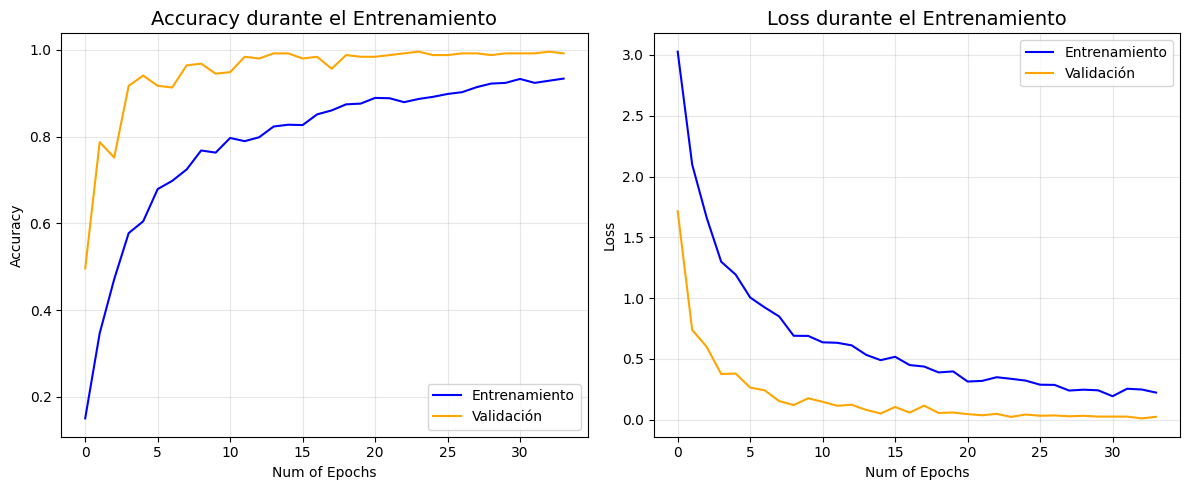

In [ ]:
# =============================================
# Visualizar Curvas de Aprendizaje
# =============================================

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='blue')
plt.plot(history.history['val_accuracy'], label='Validación', color='orange')
plt.title('Accuracy durante el Entrenamiento', fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('Num of Epochs')
plt.legend()
plt.grid(alpha=0.3)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='blue')
plt.plot(history.history['val_loss'], label='Validación', color='orange')
plt.title('Loss durante el Entrenamiento', fontsize=14)
plt.ylabel('Loss')
plt.xlabel('Num of Epochs')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:

# =============================================
# 1. Cargar el modelo
# =============================================

model_path = '/content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA/best_model_fold4.keras'
model = load_model(model_path)

# =============================================
# 2. Configurar Generador de Test (CORREGIDO)
# =============================================
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=target_size,
    batch_size=batch_size,
    color_mode=color_mode,
    class_mode=class_mode,
    shuffle=False  # Fundamental para métricas confiables
)


# Verificación crítica
print("Clases detectadas:", test_generator.class_indices)  # Debe mostrar 'A', 'B', etc.
print("Número de clases:", test_generator.num_classes)    # Debe ser 26

# Verificación crítica
print(f"Clases detectadas: {test_generator.num_classes}")  # Debe mostrar 26
print(f"Total de imágenes: {test_generator.samples}")  # Verifica el número de imágen

Found 285 images belonging to 26 classes.
Clases detectadas: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
Número de clases: 26
Clases detectadas: 26
Total de imágenes: 285


In [ ]:
# =============================================
# 2. Evaluar el Modelo
# =============================================
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9993 - loss: 0.0213
Test Accuracy: 99.65%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


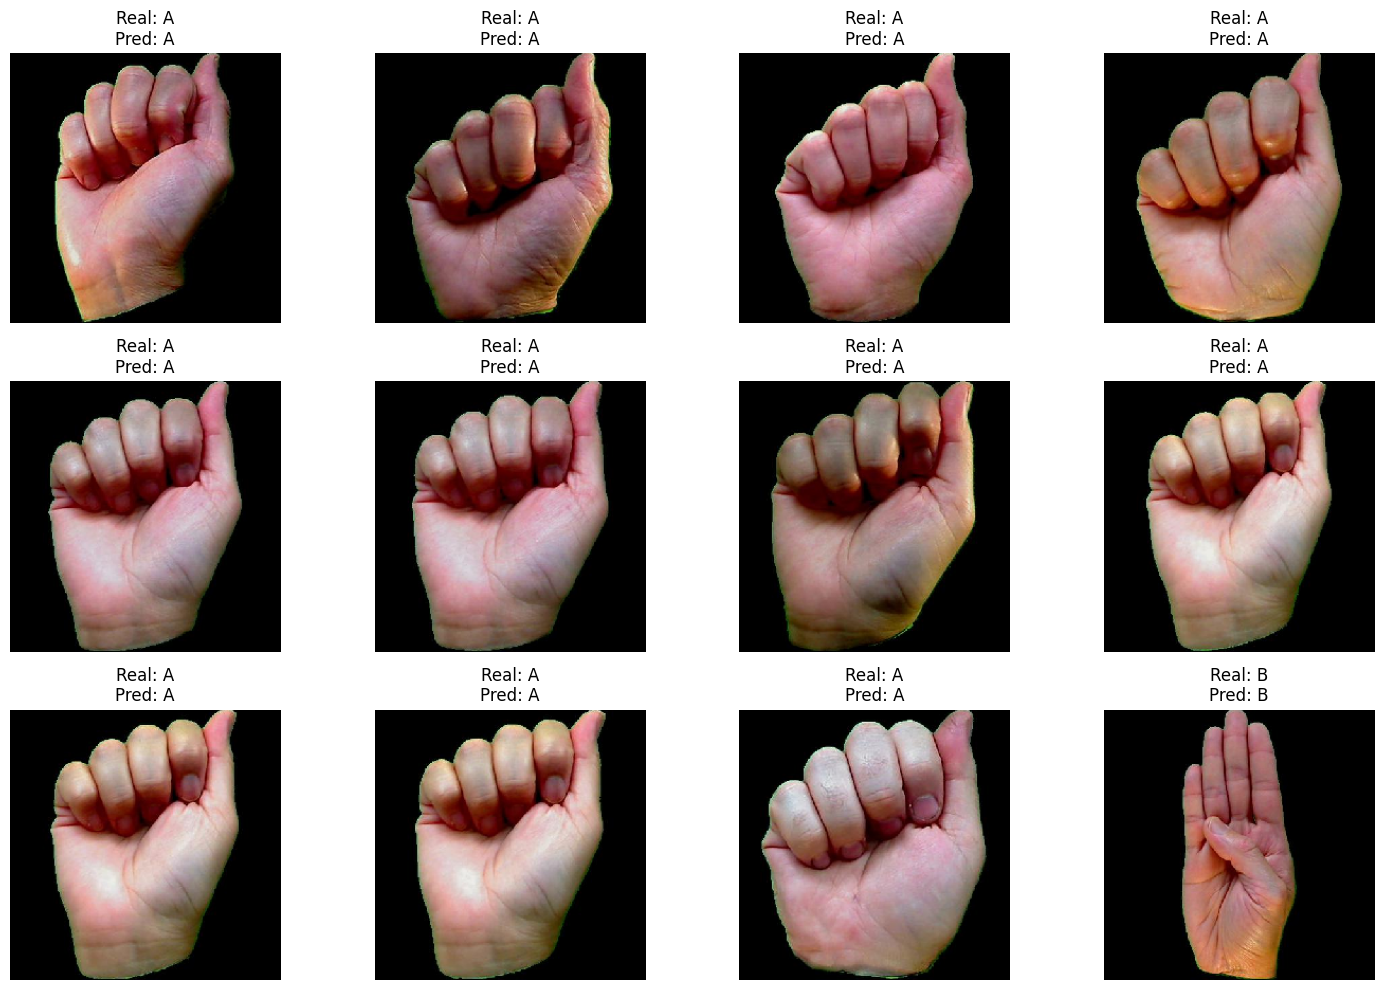

In [ ]:
# =============================================
# 4. Ver Predicciones en Imágenes de Test
# =============================================

# Obtener un batch de imágenes y etiquetas
test_images, test_labels = next(test_generator)

# Predecir
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Obtener nombres de las clases
class_names = list(test_generator.class_indices.keys())

# Mostrar resultados
plt.figure(figsize=(15, 10))
for i in range(12):  # Muestra 12 imágenes
    plt.subplot(3, 4, i+1)
    plt.imshow(test_images[i])
    plt.title(f'Real: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step


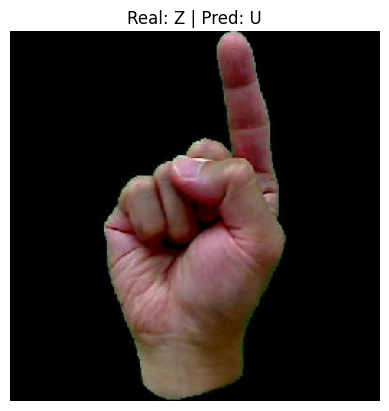

In [ ]:
# Obtener todas las predicciones
y_pred = model.predict(test_generator).argmax(axis=1)
y_true = test_generator.classes

# Encontrar índices de predicciones incorrectas
incorrect_indices = np.where(y_pred != y_true)[0]

# Mostrar imágenes mal clasificadas
for idx in incorrect_indices:
    # Obtener imagen y etiquetas
    img = test_generator[idx // test_generator.batch_size][0][idx % test_generator.batch_size]
    true_class = list(test_generator.class_indices.keys())[y_true[idx]]
    pred_class = list(test_generator.class_indices.keys())[y_pred[idx]]

    # Visualizar
    plt.imshow(img)
    plt.title(f"Real: {true_class} | Pred: {pred_class}")
    plt.axis('off')
    plt.show()

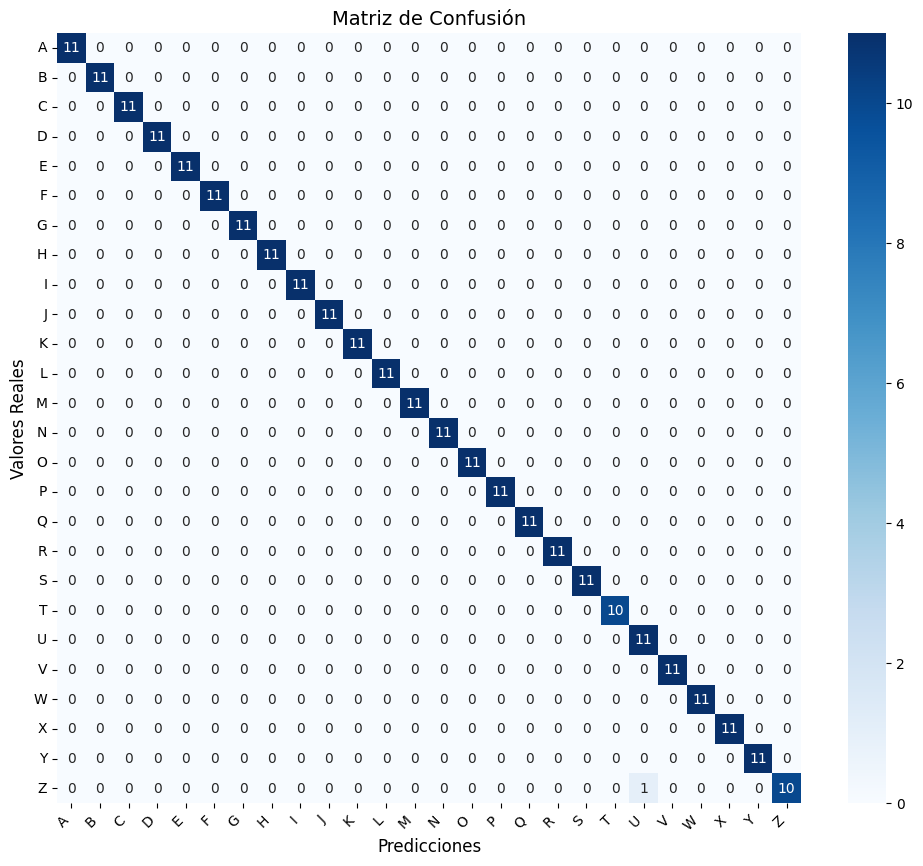

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusión', fontsize=14)
    plt.xlabel('Predicciones', fontsize=12)
    plt.ylabel('Valores Reales', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

# Usar la función
plot_confusion_matrix(y_true, y_pred, class_names)

In [ ]:
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Métricas adicionales
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"\nMétricas Resumidas:")
print(f"Exactitud (Accuracy): {accuracy_score(y_true, y_pred):.4f}")
print(f"Precisión Promedio: {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Recall Promedio: {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"F1-Score Promedio: {f1_score(y_true, y_pred, average='weighted'):.4f}")


Reporte de Clasificación:
              precision    recall  f1-score   support

           A     1.0000    1.0000    1.0000        11
           B     1.0000    1.0000    1.0000        11
           C     1.0000    1.0000    1.0000        11
           D     1.0000    1.0000    1.0000        11
           E     1.0000    1.0000    1.0000        11
           F     1.0000    1.0000    1.0000        11
           G     1.0000    1.0000    1.0000        11
           H     1.0000    1.0000    1.0000        11
           I     1.0000    1.0000    1.0000        11
           J     1.0000    1.0000    1.0000        11
           K     1.0000    1.0000    1.0000        11
           L     1.0000    1.0000    1.0000        11
           M     1.0000    1.0000    1.0000        11
           N     1.0000    1.0000    1.0000        11
           O     1.0000    1.0000    1.0000        11
           P     1.0000    1.0000    1.0000        11
           Q     1.0000    1.0000    1.0000        11
